# Домашнее задание по обработке текстов

## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [4]:
import pandas as pd
df = pd.read_csv('texts.csv')
df.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


In [5]:
pr_all = pd.read_csv('gazprom_prices.csv', sep=';')
pr_all['ClosingPrice'] = pr_all['ClosingPrice'].apply(lambda x: float(x.split()[0].replace(',', '')))
pr_all['VolumePcs'] = pr_all['VolumePcs'].apply(lambda x: float(x.split()[0].replace(',', '')))

### Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

In [6]:
import re
regex = re.compile("[А-Яа-я----]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.text = df.text.apply(words_only)


from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', '-', '-']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
df.text = df.text.apply(remove_stopwords)

In [9]:
df=df.rename(columns = {'date':'Date'})

In [10]:
df.head()

,Date,text
0,09.11.2017,компания рассчитывать решение газовый спор укр...
1,08.11.2017,предполагать ъ газпром воспользоваться жалоба ...
2,01.11.2017,новый редакция американский санкция ставить уг...
3,30.10.2017,становиться известно ъ известный рынок риск-ме...
4,23.10.2017,новатэк который пять год собираться запускать ...


## Корреляция цены закрытия и длинны текста


In [11]:
#merged = df.join(pr_all,rsuffix='Date')

In [12]:
merged = pd.merge(df, pr_all, how='inner', on='Date')

In [13]:
merged.head()

,Date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,09.11.2017,компания рассчитывать решение газовый спор укр...,"132,31",13150.0,"132,82","131,14",3.386965e+09
1,08.11.2017,предполагать ъ газпром воспользоваться жалоба ...,"132,00",13230.0,"133,94","131,58",3.938196e+09
2,01.11.2017,новый редакция американский санкция ставить уг...,"126,40",12650.0,"126,89","125,97",1.823255e+09
3,30.10.2017,становиться известно ъ известный рынок риск-ме...,"125,96",12598.0,"126,93","125,53",1.926334e+09
4,23.10.2017,новатэк который пять год собираться запускать ...,"127,05",12680.0,"127,47","126,37",1.730880e+09


In [14]:
s = merged.text.str.len().sort_values().index

In [15]:
df_by_text_length = merged.reindex(s).dropna()

In [16]:
df_by_text_length = df_by_text_length.reset_index(drop=True)

In [17]:
df_by_text_length=df_by_text_length.rename(columns = {'text':'Text'})

In [18]:
df2 = merged.text.str.len()

In [19]:
result = pd.concat([df_by_text_length, df2], axis=1, join='inner')

In [20]:
result['Date'] = pd.to_datetime(result.Date)

In [21]:
result = result.sort_values(by='Date')

In [22]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8,6
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [23]:
result =  result.reset_index()
result.head()

,index,Date,Text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,text
0,100,2010-01-02,газпром исключать г выпуск облигация примерно ...,"184,74",18985.0,"190,40","183,50",7.629818e+09,466
1,370,2010-01-19,газпром готовый забирать весь объем азербайджа...,"190,10",18976.0,"190,47","187,36",4.862673e+09,474
2,628,2010-01-28,консорциум глава российский оао газпром нефть ...,"183,75",18230.0,"185,98","181,67",6.256124e+09,873
3,195,2010-02-07,газпромбанк открывать кипр дочерний компания и...,"144,80",14825.0,"148,27","144,05",4.176663e+09,439
4,729,2010-02-09,газпром вновь понижать прогноз экспорт европа ...,"161,79",16280.0,"163,57","161,53",4.272103e+09,922


In [24]:
useful_cols = ['ClosingPrice', 'text']

In [25]:
data = result[useful_cols]

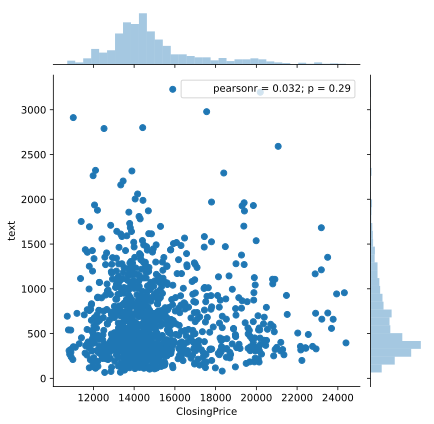

In [26]:
sns.jointplot(x='ClosingPrice', y='text', data=data, kind='scatter')

Без выбросов получили почти нормальное распределение

## Алексей Милллер и закрытие. Поскольку текст предобработан, ищем по слову "миллер".

In [27]:
with_miller = result[result['Text'].str.contains("миллер")]

In [28]:
with_miller['ClosingPrice'].mean()

14982.855670103092

In [29]:
result['ClosingPrice'].mean()    

14990.29694323144

## Потоки

In [30]:
north = result[result['Text'].str.contains("север")]

In [31]:
turkey = result[result['Text'].str.contains("турция")]

In [32]:
print (len(turkey))

34


In [33]:
print (len(north))

55


## Санкции

In [34]:
sanctions = result[result['Text'].str.contains("санкция")]

In [36]:
sanctions.Text.head()

49     газпром видеть основание снижение цена газ укр...
105    украина рассчитывать снижение цена российский ...
184    россия который хотеть терять возможность прису...
529    газпром обжаловать вильнюсский окружной админи...
553    председатель совет директор транснефть член на...
Name: Text, dtype: object

## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [32]:
price = result['ClosingPrice'].tolist()

In [33]:
price2 = []
i = 0

In [34]:
ClosingPrice_bin = [0] + [1 if price[i] > price[i-1] else 0  for i in range(1, len(price))]

In [35]:
ClosingPrice_bin = pd.DataFrame(ClosingPrice_bin, columns=['ClosingPrice_bin'])

In [36]:
data = pd.concat([result, ClosingPrice_bin], axis=1, join='inner')


In [37]:
split_date = datetime.date(2016,1,1)

training_set = data[(pd.to_datetime(data["Date"]) < split_date)]
test_set = data[(pd.to_datetime(data["Date"]) >= split_date)]


In [38]:
X_train = training_set.Text
X_test = test_set.Text

In [39]:
y_train = training_set.ClosingPrice_bin
y_test = test_set.ClosingPrice_bin

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


In [42]:
from sklearn.metrics import accuracy_score


In [47]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer

In [52]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
     ('tfidf', TfidfTransformer()),
     
    ('clf', MultinomialNB()),
])

In [53]:
clf

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [55]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [58]:
predicted = clf.predict(X_test)

In [57]:
from sklearn.metrics import accuracy_score

In [60]:
accuracy_score(predicted, y_test)

0.54150197628458496

## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     